===== Best solution (normalized objective) =====
Best total loss: 0.39498151025989964
 walk_cost     : 0.030029644943512356 (term in total)
 overflow_cost : 0.3162924220378277 (term in total)
 imbalance_cost: 0.036899443278559575 (term in total)
 build_cost    : 0.011760000000000001 (term in total)
 active stations (k): 114

--- Raw metrics (unit-sensitive) ---
  walk_raw      : 160608.41728625871
  overflow_raw  : 32172.0
  imbalance_raw : 4.889732015768182
  build_raw (k) : 114.0

--- Normalized (unit-robust) ---
  walk_norm     : 0.030029644943512356
  overflow_norm : 0.3162924220378277
  imbalance_norm: 0.036899443278559575
  build_norm    : 0.019600000000000003
  dist_scale used: 52.58099885260483

===== Unit scaling check (Dist * 1000) =====
walk_norm (original): 0.030029644943512356
walk_norm (scaled)  : 0.030029644943512377
total (original)    : 0.39498151025989964
total (scaled)      : 0.3949815102598997


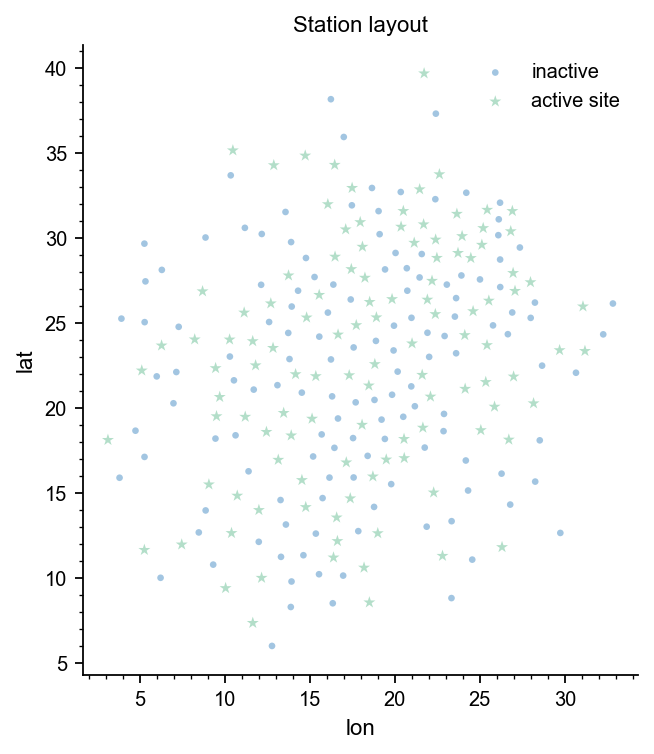

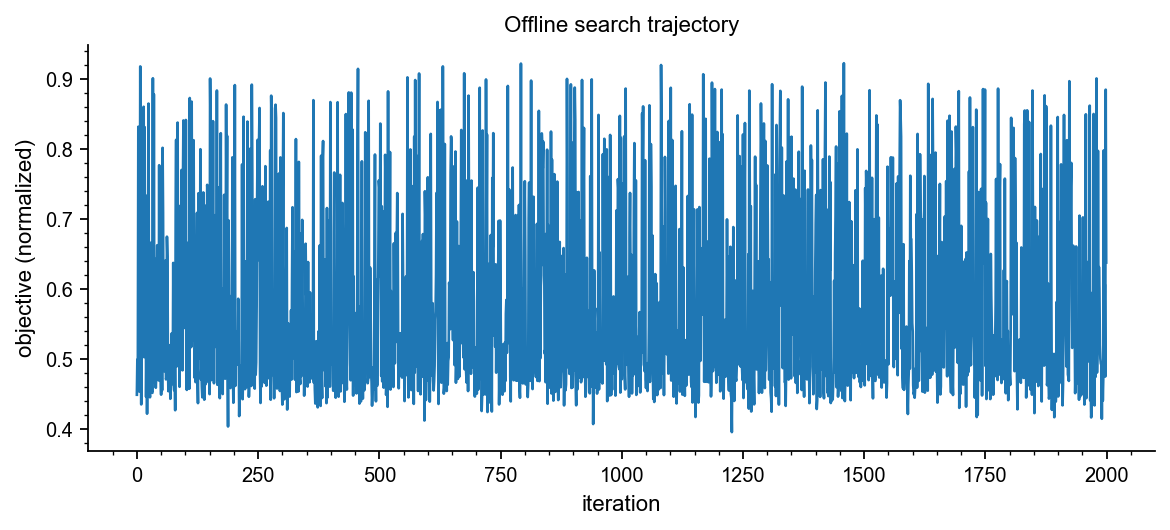

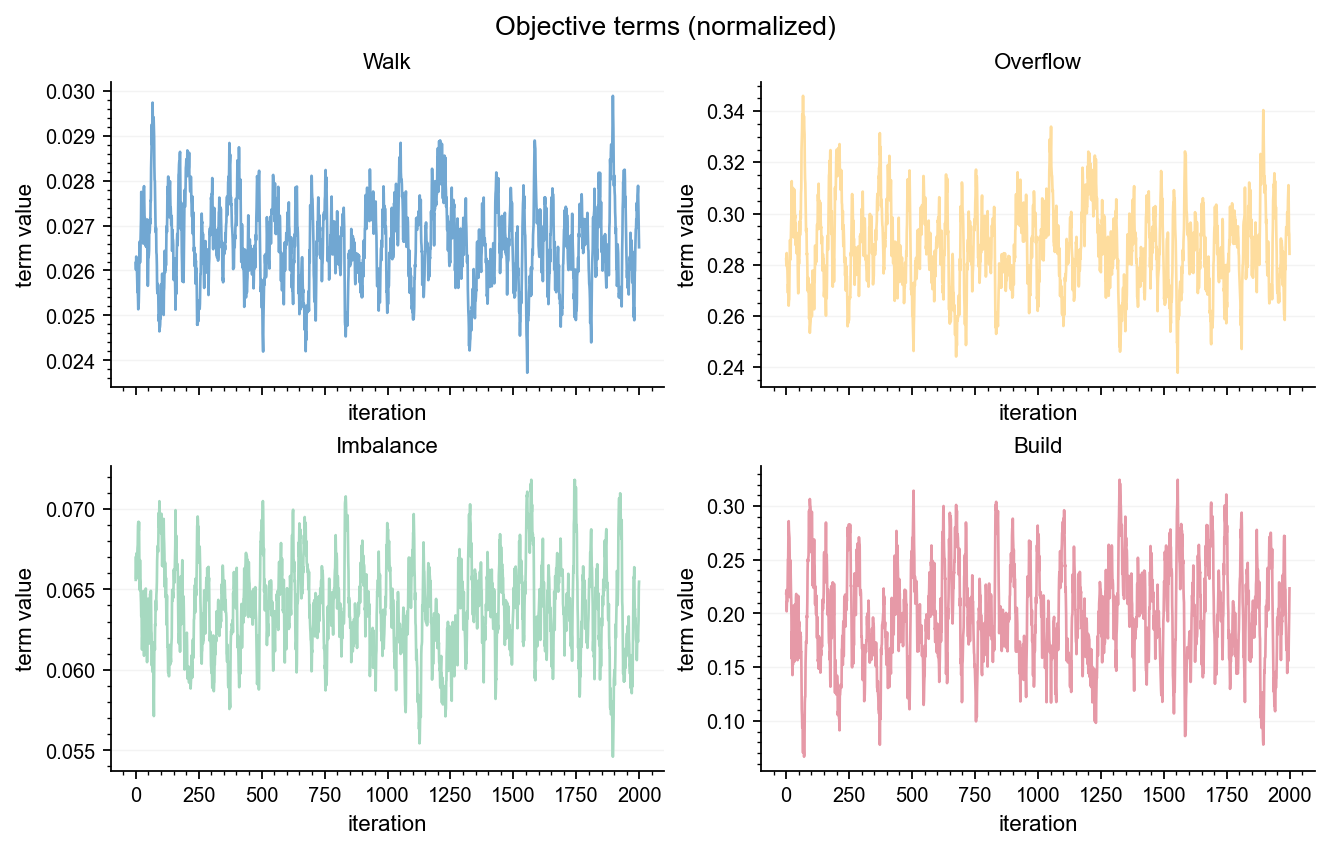

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from src.data_prep import load_data
from src.offline_model import random_search, evaluate_solution
from src.viz import set_journal_style, plot_station_layout, plot_offline_history, plot_objective_terms_separated

set_journal_style()

# =========================
# 1) 读取数据
# =========================
D, Dist, cap, meta, stations = load_data("data/processed")

J_COUNT = len(meta["J_ids"])
I_COUNT = len(meta["I_ids"])
GRID_N = int(np.sqrt(I_COUNT))

# =========================
# 2) 设置预算与搜索规模
# =========================
BUDGET_MIN_RATIO = 0.40
BUDGET_MAX_RATIO = 0.80
budget_min = int(np.ceil(BUDGET_MIN_RATIO * J_COUNT))
budget_max = int(np.floor(BUDGET_MAX_RATIO * J_COUNT))

# 随机搜索次数：可以按 J 线性放大
SAMPLES_FACTOR = 8
n_samples = int(SAMPLES_FACTOR * J_COUNT)

# =========================
# 3) 权重（建议先都用 O(1)）
#    normalize_terms=True 后，各项变成“无量纲/同量级”，再调权重更稳
# =========================
alpha_walk = 1.0
lam_over = 1.0
mu_imb = 1.0

# 建站惩罚强度：越大越不鼓励“开很多站点”
eta_build = 0.6

# 站点惩罚形状：
#  - station_penalty_power > 1 会“凸增/下凸”（站点越多，边际惩罚越大）
station_penalty_mode = "minmax"
station_penalty_power = 2.0

best, history = random_search(
    D, Dist, cap,
    budget_min=budget_min,
    budget_max=budget_max,
    n_samples=n_samples,
    alpha_walk=alpha_walk,
    lam_over=lam_over,
    mu_imb=mu_imb,
    eta_build=eta_build,
    normalize_terms=True,
    station_penalty_mode=station_penalty_mode,
    station_penalty_power=station_penalty_power,
    imbalance_scale="logJ",
    rng_seed=42,
)

print("===== Best solution (normalized objective) =====")
print("Best total loss:", best["total"])
print(" walk_cost     :", best["walk_cost"], "(term in total)")
print(" overflow_cost :", best["overflow_cost"], "(term in total)")
print(" imbalance_cost:", best["imbalance_cost"], "(term in total)")
print(" build_cost    :", best["build_cost"], "(term in total)")
print(" active stations (k):", int(best["y"].sum()))
print("\n--- Raw metrics (unit-sensitive) ---")
print("  walk_raw      :", best["walk_raw"])
print("  overflow_raw  :", best["overflow_raw"])
print("  imbalance_raw :", best["imbalance_raw"])
print("  build_raw (k) :", best["build_raw"])

print("\n--- Normalized (unit-robust) ---")
print("  walk_norm     :", best["walk_norm"])
print("  overflow_norm :", best["overflow_norm"])
print("  imbalance_norm:", best["imbalance_norm"])
print("  build_norm    :", best["build_norm"])
print("  dist_scale used:", best["dist_scale"])

# =========================
# 4) 单位缩放鲁棒性自检（老师建议）
#    把 Dist 全部乘 1000（km->m），walk_norm 应基本不变
# =========================
m1 = evaluate_solution(
    D, Dist, cap, best["y"],
    alpha_walk=alpha_walk, lam_over=lam_over, mu_imb=mu_imb, eta_build=eta_build,
    normalize_terms=True,
    station_penalty_mode=station_penalty_mode,
    station_penalty_power=station_penalty_power,
    budget_min=budget_min, budget_max=budget_max,
    dist_scale=None,  # 让它随输入 Dist 自动取尺度
)
m2 = evaluate_solution(
    D, Dist * 1000.0, cap, best["y"],
    alpha_walk=alpha_walk, lam_over=lam_over, mu_imb=mu_imb, eta_build=eta_build,
    normalize_terms=True,
    station_penalty_mode=station_penalty_mode,
    station_penalty_power=station_penalty_power,
    budget_min=budget_min, budget_max=budget_max,
    dist_scale=None,
)

print("\n===== Unit scaling check (Dist * 1000) =====")
print("walk_norm (original):", m1["walk_norm"])
print("walk_norm (scaled)  :", m2["walk_norm"])
print("total (original)    :", m1["total"])
print("total (scaled)      :", m2["total"])

# =========================
# 5) 可视化
# =========================
plot_station_layout(stations, y=best["y"])
plot_offline_history(history)
plot_objective_terms_separated(history, normalized=True, rolling=15)

In [3]:
# --- Safety defaults for comparison cell (does NOT change your original pipeline) ---
# This cell assumes you have run Cell 0 and computed: D, Dist, cap, stations, best, and the weights.
if "best" not in globals():
    raise RuntimeError("Please run Cell 0 first to obtain `best` before running this comparison cell.")

alpha_walk = globals().get("alpha_walk", 1.0)
lam_over   = globals().get("lam_over", 1.0)
mu_imb     = globals().get("mu_imb", 1.0)
eta_build  = globals().get("eta_build", 0.6)

# Optional knobs (if you didn't define them above, use evaluate_solution defaults)
normalize_terms       = globals().get("normalize_terms", True)
station_penalty_mode  = globals().get("station_penalty_mode", "minmax")
station_penalty_power = globals().get("station_penalty_power", 2.0)
budget_min            = globals().get("budget_min", None)
budget_max            = globals().get("budget_max", None)
imbalance_scale       = globals().get("imbalance_scale", "logJ")


# =========================================================
# 6) Algorithm comparison baselines: k-median vs k-center vs k-supplier
#    (Does NOT change your original result. It only adds baselines.)
# =========================================================
import pandas as pd
import numpy as np

from src.offline_model import greedy_kcenter, greedy_ksupplier, distance_stats, evaluate_solution

# Use the same k as the best solution found above (fair comparison).
k = int(best["y"].sum())
print("Compare under the same station budget k =", k)

# Baseline A: your current best (k-median-style + penalties, via random_search)
y_kmedian = best["y"]

# Baseline B: k-supplier greedy (worst-case coverage intuition, unweighted)
y_ksupplier = greedy_ksupplier(D, Dist, k, seed=0)

# Baseline C: k-center-style greedy with mild demand-awareness (gamma=0.5)
# gamma=0.0 would behave almost the same as k-supplier in this setting.
y_kcenter = greedy_kcenter(D, Dist, k, seed=0, gamma=0.5)

def summarize(name, y):
    m = evaluate_solution(
        D, Dist, cap, y,
        alpha_walk=alpha_walk, lam_over=lam_over, mu_imb=mu_imb, eta_build=eta_build,
        normalize_terms=normalize_terms,
        station_penalty_mode=station_penalty_mode,
        station_penalty_power=station_penalty_power,
        budget_min=budget_min, budget_max=budget_max,
        dist_scale=None,
        imbalance_scale=imbalance_scale,
    )
    ds = distance_stats(D, Dist, y, q=0.95)
    return dict(
        algorithm=name,
        k=int(np.sum(y > 0.5)),
        total=m["total"],
        walk_cost=m["walk_cost"],
        overflow_cost=m["overflow_cost"],
        imbalance_cost=m["imbalance_cost"],
        build_cost=m["build_cost"],
        wmean_dist=ds["wmean_dist"],
        wp95_dist=ds["wpq_dist"],
        max_dist=ds["max_dist"],
    )

rows = [
    summarize("k-median (your objective)", y_kmedian),
    summarize("k-supplier (greedy farthest-first)", y_ksupplier),
    summarize("k-center (greedy, demand-aware gamma=0.5)", y_kcenter),
]

df = pd.DataFrame(rows).set_index("algorithm")

Compare under the same station budget k = 114



Layout: k-median (your objective)


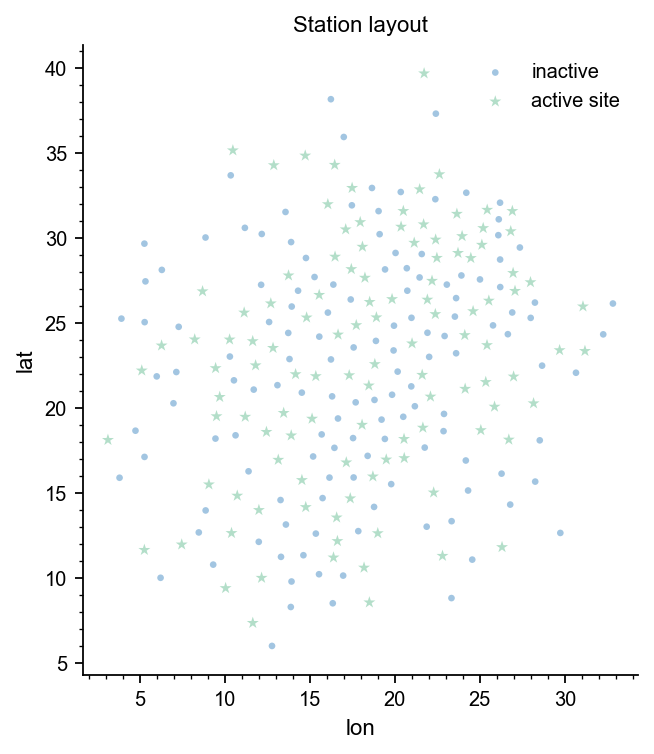


Layout: k-supplier (greedy farthest-first)


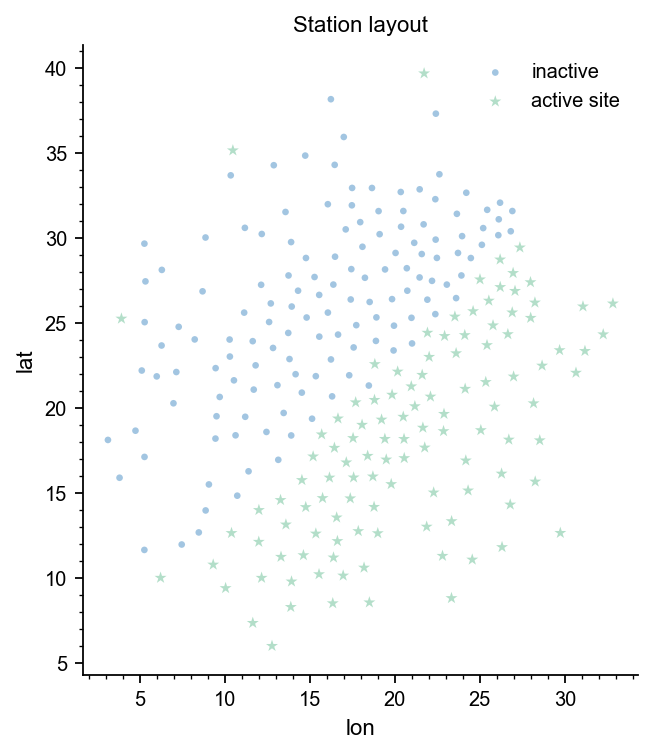


Layout: k-center (demand-aware gamma=0.5)


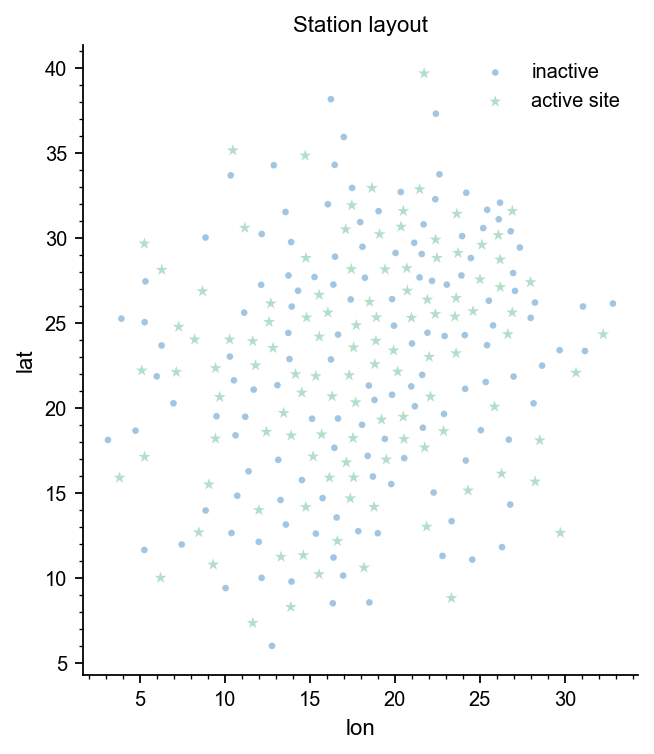

In [4]:

# =========================================================
# 7) Visualize the three layouts (same k, different objectives)
# =========================================================
from src.viz import plot_station_layout

print("\nLayout: k-median (your objective)")
plot_station_layout(stations, y=y_kmedian)

print("\nLayout: k-supplier (greedy farthest-first)")
plot_station_layout(stations, y=y_ksupplier)

print("\nLayout: k-center (demand-aware gamma=0.5)")
plot_station_layout(stations, y=y_kcenter)
